# 18-9. 프로젝트 : 다양한 OCR모델 비교하기

우리는 지금까지 Google OCR API, keras-ocr, Tesseract 이상 3가지의 OCR 기능을 간단히 활용하여 보았습니다.

지금까지 살펴본 바로는 무료로 사용할 수 있는 기능들이지만 모두 준수한 성능을 갖추고 있었습니다. OCR 분야가 이미 실용적인 수준에까지 기술이 발전했기 때문에 이런 것들만 잘 활용해도 실전에 활용할 수 있는 좋은 서비스를 만들어 낼 수 있을 것도 같습니다. 그런데 과연 어떤 것을 사용하는 것이 좋을까요?

OCR 기술들이 실용적인 수준까지 꽤 발전했지만 그럼에도 불구하고 아직 완전한 수준은 아닙니다. 용도에 맞게 적절한 것을 선택하는 것도 중요한 일입니다. 그래서 오늘 다뤄본 위 3가지를 검증해 보는 프로젝트를 진행하겠습니다. 여러분은 OCR 기능을 활용한 서비스를 빠르게 개발해야 하는 임무를 맡은 엔지니어가 되어, 어떤 모듈을 도입하면 좋을지 기술검증을 하는 역할을 맡게 되었다고 가정합니다.

### 목차

#### Step1. 검증용 데이터셋 준비

#### Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

#### Step3. 테스트 결과 정리

#### Step4. 결과 분석과 결론 제시

#### Step5. 루브릭 & 회고

## Step1. 검증용 데이터셋 준비
---
OCR 관련해서 오늘 다루어본 주제는 텍스트의 모양과 크기, 배치, 노이즈 등 OCR의 성능에 영향을 미치는 요인들에 관한 것이었습니다. 여러분들은 위 3가지 기능들이 이미지에 나타난 특징에 따라 얼마나 정확하게 문자를 detect하고 recognize하는지를 검증하기 위한 이미지 데이터를 모아야 합니다. 이미지가 많을수록 좋겠지만 검증해야 할 항목별로 고루 갖춰지는 것도 중요합니다.

가능하다면 함께 학습하는 동료들과 힘을 합쳐보는 것을 추천합니다. 그렇다고 너무 많은 이미지 데이터로 검증하는 것은 이후 결과를 정리하는 것이 힘들 수 있으니 테스트용 이미지는 아무리 많아도 20장을 넘기지 않는 것으로 합시다.

### 1-1. 프로젝트 목적

- 평소에 제가 찍었던 스냅 사진 중, 텍스트가 포함된 이미지로 선별하여 다양한 피사체가 있는 사진 속에서 텍스트를 판별할 수 있는 지 확인해 보도록 하겠습니다.

In [1]:
# 필요한 라이브러리 import
import os
import glob

import cv2

import matplotlib.pyplot as plt
import matplotlib.image as img

# Google OCR API
from google.cloud import vision
import io
from PIL import ImageDraw

# keras-ocr
import keras_ocr

# tesseract
import pytesseract
from PIL import Image
from pytesseract import Output
import re

### 1-2. 데이터셋 구축

In [2]:
# load images
image_path = os.getenv('HOME')+ '/aiffel/ocr_python/test_image'
file_list = sorted(os.listdir(image_path))  # 파일명 순으로 정렬
file_list

['IMG01.JPG',
 'IMG02.JPG',
 'IMG03.JPG',
 'IMG04.JPG',
 'IMG05.JPG',
 'IMG06.JPG',
 'IMG07.JPG',
 'IMG08.JPG',
 'IMG09.JPG',
 'IMG10.JPG']

- 이미지는 총 10장으로 선별해 보았습니다.

## Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행
---
위 3가지 모듈을 활용하는 방법에 대해서는 코드 레벨로 이미 경험해 보셨을 것입니다.

이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아 봅시다.

### 2-1. Google OCR API
---

In [3]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))
       vertices = (['({},{})'.format(vertex.x, vertex.y)
       for vertex in text.bounding_poly.vertices])
       print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

[os.path.join 함수]

- 경로(패스)명 조작에 관한 처리를 모아둔 모듈로써 구현되어 있는 함수
- 경로와 피일명을 결합, 분할된 경로를 하나로 정리하거나하는 것이 가능

출처: https://engineer-mole.tistory.com/188 [매일 꾸준히, 더 깊이]

In [4]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for file in file_list:
    print(f'[{file}]')
    detect_text(os.path.join(image_path, file))  

    print('the end')

[IMG01.JPG]
Texts:

"Cofe Winthers
A CHRISTMAS CAROL
Crathi sld bw e lad
KSMe Po, wh void ring
wrky The tw
Crh ghed
and Pror id
ellam
thougholaly at he bee
www.d ting wt particaliar ineste
rm e came it dhe i of that
ha, whs wasa p ie
what ind of wak she
ohe warked a
bed t e mieg, te
beinga day dhe paed
a s and a ld
uc about
llar
I you had
jag went
Trier pulled w
his bd
seng, abet
Tiny Ti w
Cobry well indred
hsThey w
wl dred
the Wenther
theie ehen
D they wor
and coned
appier
th at p
spun them, nt especially en
f the
yeg dk, snd ing pretty
de a wt aleng she
ring ih
I rm, wa wndertl M
anians ee
and thegh
M pen ing
"
bounds: (229,235),(501,235),(501,503),(229,503)

"Cofe"
bounds: (298,376),(355,381),(352,412),(295,407)

"Winthers"
bounds: (358,381),(445,389),(442,420),(355,412)

"A"
bounds: (502,419),(500,423),(494,421),(497,416)

"CHRISTMAS"
bounds: (501,423),(486,453),(482,452),(497,421)

"CAROL"
bounds: (483,457),(474,475),(470,473),(479,455)

"Crathi"
bounds: (491,422),(477,450),(472,4

- 이미지 안에 있는 영어와 한글을 전체적으로 잘 검출 하고 있음을 확인 할 수 있습니다.

### 2-2. keras-ocr
---
- Keras OCR 자세히 보기 (https://keras-ocr.readthedocs.io/en/latest/index.html)
- 한글 데이터셋으로 훈련이 되지 않은 모델, detection은 정상적으로 진행되더라도 recognition 결과가 엉뚱하게 나올 수 있음에 주의

In [5]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [6]:
# 테스트에 사용할 이미지 모으기, 기존 노드는 url이나 os.path.join(image_path, file) 으로 변경 필요 

images = [keras_ocr.tools.read(os.path.join(image_path, file)) for file in file_list]
prediction_groups = [pipeline.recognize([os.path.join(image_path, file)]) for file in file_list]

- recognize() 는 검출기와 인식기를 두고, 검출기로 바운딩 박스(bounding box, 문자가 있는 영역을 표시한 정보)를 검출한 뒤, 인식기가 각 박스로부터 문자를 인식하는 과정을 거치도록 한다.

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


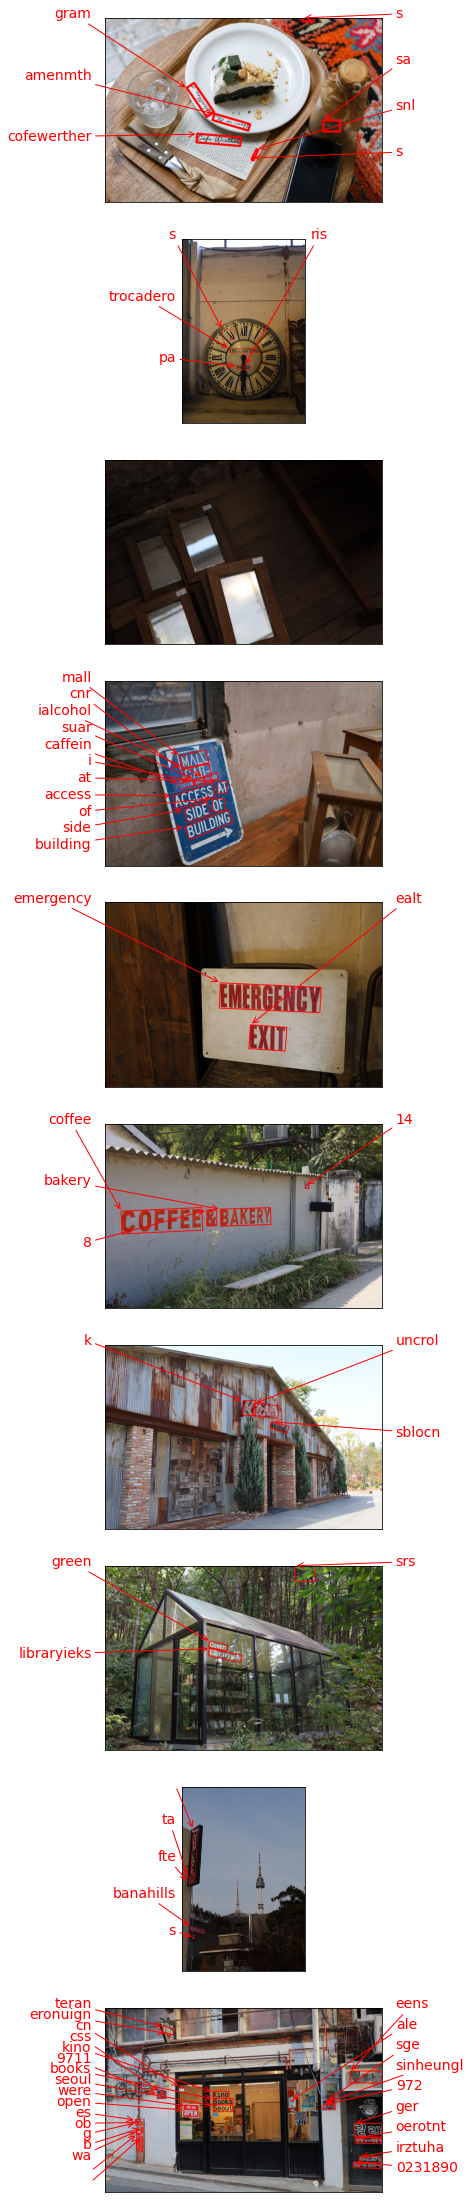

In [7]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(40, 40))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### 2-3. Tesseract
---
테서랙트를 사용하면 한 번에 이미지 내의 문자 검출과 인식을 할 수 있는데요.

우리는 OCR이 이뤄지는 전체 과정을 직접 거쳐보기 위해 검출을 먼저 해 봅시다.

- crop_word_regions()함수: 선택한 테스트 이미지를 받아, 문자 검출 진행 후, 검출된 문자 영역을 crop 이미지로 만들고 그 파일들의 list 리턴

In [52]:
# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [53]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/test_image'
img_file_path = work_dir + '/IMG10.JPG'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

In [54]:
cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

AttributeError: type object 'Image' has no attribute 'open'

- 테서랙트로 잘린 이미지에서 단어 인식하기

In [55]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(  #검출된 바운딩 박스 별로 잘린 이미지를 넣어주면 영역별 텍스트가 결괏값으로 나온다.
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

AttributeError: type object 'Image' has no attribute 'open'

- Tesseract OCR 에서는 저의 실수인지, Tesseract가 이미지에서 텍스트를 검출하지 못 하는 것인지 알 수는 없지만, 성능 파악을 제대로 할 수 없었습니다.

## Step3. 테스트 결과 정리
---
모듈들마다 출력 형태가 다릅니다. 분석을 위해 결과를 일목요연하게 정리해 보는 것이 도움이 될 것입니다.

시각화 방법이 함께 활용된다면 더욱 좋겠군요.

<function matplotlib.pyplot.show(close=None, block=None)>

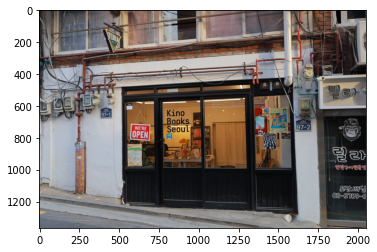

In [46]:
# 테스트 이미지 확인
ocr_image = os.getenv('HOME')+'/aiffel/ocr_python/test_image/IMG10.JPG'
img_bgr = cv2.imread(ocr_image)
img_rgb = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show

- 숫자, 영어, 한글 텍스트가 모두 있는 이미지로 선정하여 OCR이 원활하게 이루어지는지 확인해 보도록 하겠습니다.

### 3-1. Google-OCR

In [47]:
# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(ocr_image)

Texts:

"TERRA
FROM AG
릴라
Kino
Books
Seoul
신흥로
Sinheungr
신흥료
Sinheung-ro
97-1
97-2
WE'RE
OPEN
RICHY
릴라
신황소
연탄구이 전문정
포장 배달
02-3789-0
"
bounds: (224,133),(2047,133),(2047,1184),(224,1184)

"TERRA"
bounds: (424,133),(522,171),(504,217),(406,179)

"FROM"
bounds: (455,193),(470,199),(468,204),(453,198)

"AG"
bounds: (472,201),(480,205),(478,209),(470,206)

"릴라"
bounds: (1790,466),(2009,466),(2009,561),(1790,561)

"Kino"
bounds: (802,623),(910,623),(910,672),(802,672)

"Books"
bounds: (790,672),(939,671),(939,720),(790,721)

"Seoul"
bounds: (793,721),(957,717),(958,769),(794,773)

"신흥"
bounds: (408,619),(423,619),(423,628),(408,628)

"로"
bounds: (425,619),(432,619),(432,626),(425,626)

"Sinheungr"
bounds: (405,629),(435,629),(435,634),(405,634)

"신흥"
bounds: (1635,689),(1666,689),(1666,702),(1635,702)

"료"
bounds: (1668,689),(1670,689),(1670,702),(1668,702)

"Sinheung-ro"
bounds: (1634,703),(1677,702),(1677,708),(1634,709)

"97-1"
bounds: (380,639),(455,639),(455,673),(380,673)

"97-2"
bound

- Google-OCR 로 검출 된 결과를 보니, 숫자, 영어, 한글 텍스트 모두 잘 검출 했음을 확인 할 수 있습니다.

### 3-2. Keras-OCR

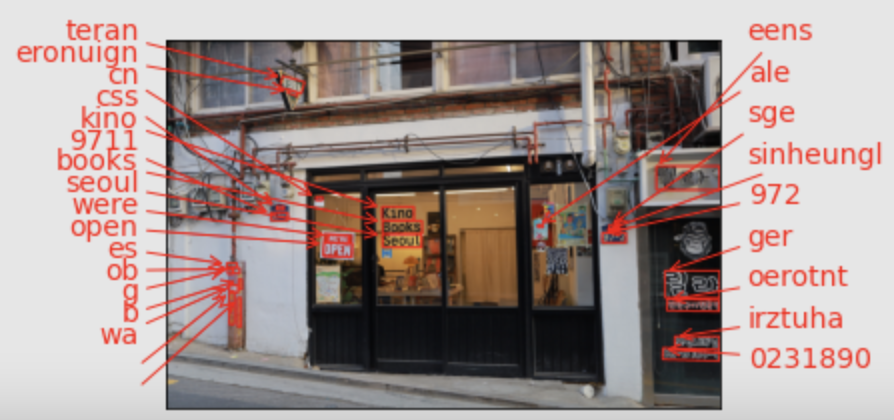

- Keras-OCR 로 검출된 결과를 보니, 영어와 숫자 그리고 그 외의 알 수 없는 텍스트를 인식하기는 하였으나 한글은 전혀 검출하지 못하였음을 확인 할 수 있었습니다.

### 3-3. Tesseract

In [51]:
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

AttributeError: type object 'Image' has no attribute 'open'

- Tesseract test 는 이미지에서 텍스트를 검출하지 못 하여, 성능 파악을 제대로 할 수 없었습니다.

## Step4. 결과 분석과 결론 제시
---
우선 여러분들이 구현하고자 하는 서비스의 목적과 내용을 먼저 정리합니다.

여러분들이 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가 기준을 제시합니다.

그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정합니다.

- 위에서 Google-OCR, keras-OCR, Tesseract에 대한 인식률을 확인해본 결과, Google OCR 가 텍스트의 종류에 상관 없이 인식을 가장 잘 하였음을 확인 할 수 있었습니다.

- 그래도 Google-OCR에서의 아쉬운 점을 한 가지 꼽자면, Keras-OCR 처럼 인식된 위치를 표시해주면 좋을 거 같다는 생각을 하였습니다.

## Step5. 루브릭 & 회고

### 루브릭

1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?

- 목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.

2. 모델 평가기준이 명확하고 체계적으로 세워졌는가?

- 평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.

3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?

- 최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.

### 회고

- 위에서 결론에서 적기도 하였으나 역시 구글 OCR로 이미지 내에 있는 영어, 한글, 숫자 등의 텍스트를 검출하다니... 역시 갓 구글... 이라는 생각을 하게 만들어주는 계기가 되었던 것 같습니다.

- 이번 프로젝트를 하며 아쉬웠던 점을 꼽자면, Google-OCR, Keras-OCR로는 이미지 내 텍스트가 검출 됨을 확인 할 수 있었지만, Tesseract 로는 제가 정확하게 어떤 실수를 한 것인지를 모르겠지만,
이미지 내 텍스트 인식을 하지 못해서 아쉬움을 남겼습니다.

- 그럼에도, 이번 프로젝트 작성자님이 일하시고 계신 스타트업 Lomin (https://www.lomin.ai/) 사이트를 서핑하며, 미래에 업무 자동화를 위해서 OCR 영역이 매우 중요하지 않을까? 라는 생각을 하게 만드는 프로젝트였다고 생각합니다.